# Load checkpoint

In [138]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader

from _config import PATH_CHECKPOINT, PATH_TO_CONFIG
from data_loader import MyDataLoader
from models import *
from my_config import MyConfig, load_config
from train import model, DEVICE, create_sequences, TimeSeriesDataset, BATCH_SIZE

# Find all checkpoint files in the directory following the pattern checkpoint_{epoch}.pt
checkpoint_files = [f for f in os.listdir(PATH_CHECKPOINT) if f.startswith('checkpoint_') and f.endswith('.pt')]
if checkpoint_files:
    # Sort files by epoch number in descending order and choose the latest checkpoint.
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)
    latest_checkpoint_file = checkpoint_files[0]

    model.load_state_dict(torch.load(PATH_CHECKPOINT / latest_checkpoint_file, map_location=DEVICE)['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint files found in {PATH_CHECKPOINT}")

# Load test data

In [139]:
# --- Reconstruct continuous one-step-ahead forecasts for 2024

# 1) Reload the full DataFrame (so we get the original timestamps)
my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.lag_features()
data_loader.prepare_df()
df_all = data_loader.get_df()

# 2) Split off features and targets, then isolate year 2024
TARGETS = [x.name for x in my_config.target_variables]
X_all = df_all.drop(columns=TARGETS)
y_all = df_all[TARGETS]
X_test = X_all.loc['2024']
y_test = y_all.loc['2024']


print(f'Before creating sequences: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
X_test, y_test, ts = create_sequences(X_test.to_numpy(), y_test.to_numpy(), y_test.index.to_numpy(), 60, rolling=True)
print(f'After creating sequences: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
test_dataset = TimeSeriesDataset(X_test, y_test, device=DEVICE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Before creating sequences: X_test shape: (245290, 3), y_test shape: (245290, 1)
After creating sequences: X_test shape: (223520, 60, 3), y_test shape: (223520, 60, 1)


# Make predictions

In [140]:
import numpy as np

model.eval()
preds = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        predictions = model(batch_X)
        preds.append(predictions.cpu().numpy())

y_test = y_test.squeeze()
preds = np.concatenate(preds).squeeze()
display(ts.shape, y_test.shape, preds.shape)

(223520, 60)

(223520, 60)

(223520, 60)

In [141]:
y_test = pd.DataFrame(y_test, index=ts[:, 0])
preds = pd.DataFrame(preds, index=ts[:, 0])
ts = pd.DataFrame(ts, index=ts[:, 0])
y_test.sort_index(inplace=True)
preds.sort_index(inplace=True)
display(y_test.head(),preds.head(), ts.head())

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0096860717591987,0.0040165655781088,0.0107700652554161,0.0139940979043658,0.0188251563298974,0.0297249826241605,0.0340569660050392,0.0312421766670029,0.0475819367788677,0.038997825165054
2024-01-01 07:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0040165655781088,0.0107700652554161,0.0139940979043658,0.0188251563298974,0.0297249826241605,0.0340569660050392,0.0312421766670029,0.0475819367788677,0.038997825165054,0.0296052090475115
2024-01-01 07:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0124769124716242,...,0.0107700652554161,0.0139940979043658,0.0188251563298974,0.0297249826241605,0.0340569660050392,0.0312421766670029,0.0475819367788677,0.038997825165054,0.0296052090475115,0.0337774880029529
2024-01-01 07:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0124769124716242,0.0057284005113977,...,0.0139940979043658,0.0188251563298974,0.0297249826241605,0.0340569660050392,0.0312421766670029,0.0475819367788677,0.038997825165054,0.0296052090475115,0.0337774880029529,0.0423017130656636
2024-01-01 07:47:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0124769124716242,0.0057284005113977,0.0136447536580965,...,0.0188251563298974,0.0297249826241605,0.0340569660050392,0.0312421766670029,0.0475819367788677,0.038997825165054,0.0296052090475115,0.0337774880029529,0.0423017130656636,0.0319508704411268


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,0.3823347,0.10744953,0.021616936,0.11225319,0.22691536,0.3060627,0.28931618,0.23511505,0.1834135,0.15206528,...,0.37823582,0.3570633,0.3337412,0.29917526,0.27134705,0.25952148,0.26219368,0.2385416,0.13935852,0.025690079
2024-01-01 07:44:00,0.38340473,0.10846901,0.020242691,0.10999012,0.22458172,0.30399895,0.28804398,0.23441124,0.18296623,0.15144444,...,0.3559351,0.33232975,0.29804516,0.26983547,0.25824165,0.26047516,0.23739052,0.13894844,0.024866104,0.11046696
2024-01-01 07:45:00,0.38179207,0.11126137,0.022351265,0.108314514,0.22059155,0.30046272,0.28597355,0.23313141,0.18195629,0.15069771,...,0.33097744,0.2963543,0.26828098,0.2564125,0.25834846,0.23607826,0.13875675,0.023498535,0.10872841,0.2570696
2024-01-01 07:46:00,0.38171768,0.11429024,0.022312164,0.10560894,0.21784973,0.29852486,0.2843361,0.23182678,0.18123436,0.14979172,...,0.29469395,0.2664833,0.25448227,0.25601387,0.23451424,0.13847065,0.022257805,0.10632801,0.2547207,0.28166008
2024-01-01 07:47:00,0.3796959,0.11772919,0.023515701,0.10416317,0.21518326,0.29582787,0.28178596,0.23060417,0.18046951,0.14883518,...,0.26543236,0.25328064,0.25481033,0.2337532,0.13847542,0.02157116,0.10477257,0.25310898,0.28007317,0.27669048


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,2024-01-01 07:43:00,2024-01-01 07:44:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,...,2024-01-01 08:33:00,2024-01-01 08:34:00,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00
2024-01-01 07:44:00,2024-01-01 07:44:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,...,2024-01-01 08:34:00,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00
2024-01-01 07:45:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,...,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00
2024-01-01 07:46:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,2024-01-01 07:55:00,...,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00,2024-01-01 08:45:00
2024-01-01 07:47:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,2024-01-01 07:55:00,2024-01-01 07:56:00,...,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00,2024-01-01 08:45:00,2024-01-01 08:46:00


# Plot predictions

<Axes: >

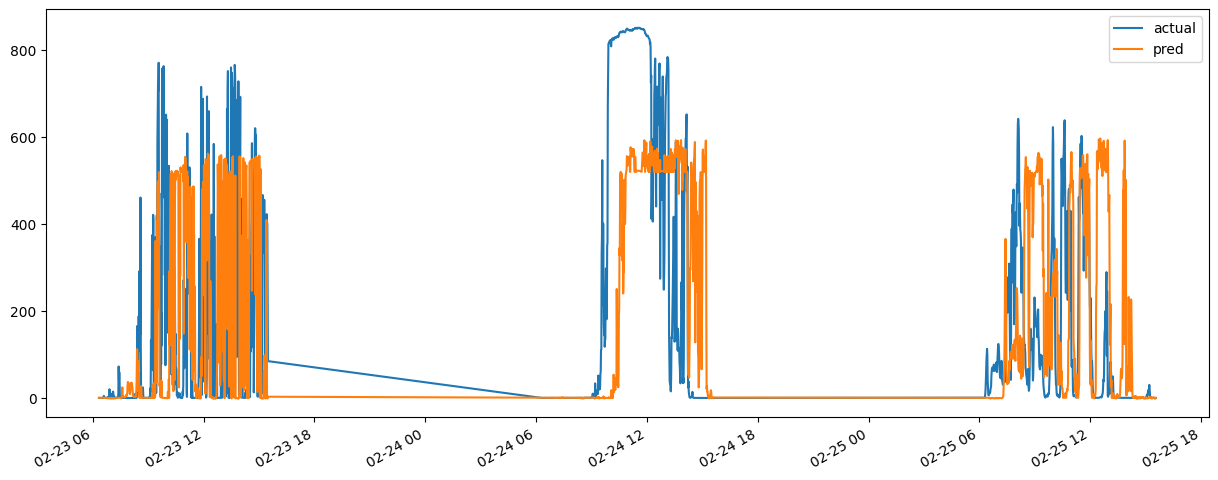

In [142]:
fig, ax = plt.subplots(figsize=(15, 6))
df.loc['2024-02-23':'2024-02-25'].plot(ax=ax)


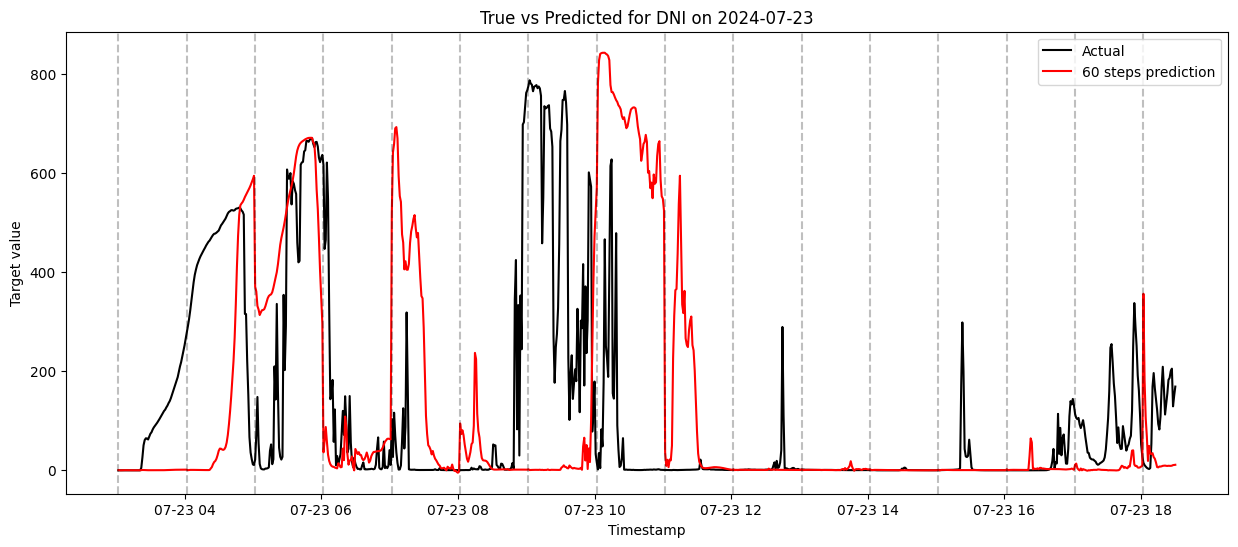

In [154]:
fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-07-23'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=1)
# Filter the timestamps for the selected day
day_mask = (ts.index >= day_start) & (ts.index < day_end)
day_ts = ts[day_mask][0].values

# Plot actual values
ax.plot(day_ts, y_test[day_mask][0].values, label='Actual', color='black')
ax.plot(day_ts, preds[day_mask][::60].values.flatten()[:len(day_ts)], label='60 steps prediction', color='red')
# add vertical lines at every 60th timestep
for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)


ax.set_title(f"True vs Predicted for {TARGETS[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.legend()
plt.show()

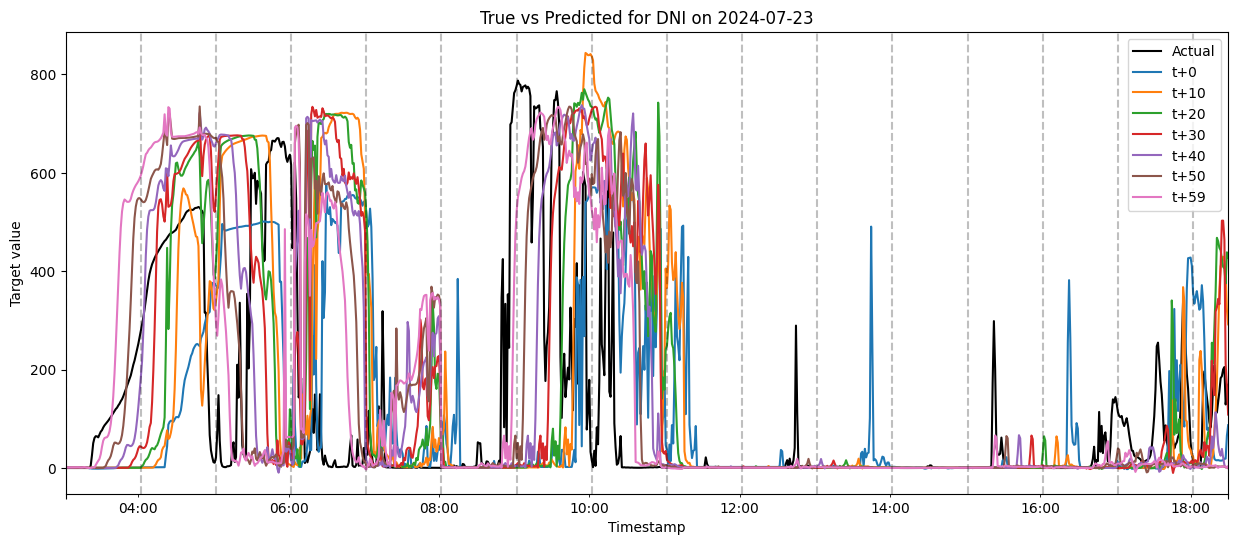

In [155]:
fig, ax = plt.subplots(figsize=(15, 6))
y_test[day_mask][0].plot(ax=ax, label='Actual', color='black', title=f"True vs Predicted for {TARGETS[0]} on {day}", xlabel="Timestamp", ylabel="Target value", legend=True)
prediction_steps = list(range(0, 60, 10))
prediction_steps.append(59)
for i in prediction_steps:
    preds[day_mask][::1][i].plot(ax=ax, label=f"t+{i}", legend=True)

for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)